# XGBoot for chemsitry ODE regression

XGBoost is a very success ensemble method for regression. Comparing to deep learning, boosting algorithms is faster and provides better interpretation to the data. Here, we are using xgboost to simulate the integration of the H2 reaction ODE. Current chemical states are given as input and the targets the new states in time $\Delta_t$.
In order to achieve the best results, this study is focused on both feature engineering and hyperparameter tuning. By comparing the importance metric comes with the tree building process, a most relevant collection of input feature are suggested. It shows that apart from mass fraction of all the species and Temperature, pregress variable and the conserved value of all the elements are helpful in the modelling building. Chemical reactions happens in a broad range. This oppose a great challenge for the gradient based optimazation algorithm such as xgboost as well as deep learning. In this study differnt scaling method has been tested and it has been found that reformating the problem into a redisual study is the most effective solution. Instead of learning for the mass fraction and temperature for the predicted state, which could vary over 10 orders of magnitute, the relative change to the current state is used as the target value. All machine learning models face the problem of bias and variance. In the ensemble method used here, the complexity of the model could affect the generalization of the prediction. In general the depth of the tree and the total number of all the trees used has a huge impact of the model quality. In order to select the best hyperparemeter a bayesian optimization is used.       

## Problem description and data analysis
To study real chemstry reaction, H2 combustion in air is chosen for its relative simplicity. The goal is to formulate a machine learning based regression model to best simulate the H2/air reaction ODE integration. The training data set is generated by a zero-D intergration of the H2/Air combustion with very fuel ratio and ambient temperature.  

In [1]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pickle

from reactor_ode_delta import ignite_post, data_gen_f
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from dataScaling import LogScaler, AtanScaler, NoScaler
# from boost_test import create_data
# create_data()
# create data
# def create_data():
#     T = np.random.rand(100) * 1000 + 1001
#     n_s = np.random.rand(1) * 7.6 + 0.1
#     n_l = np.random.rand(30) * 40

#     n = np.concatenate((n_s, n_l))
#     XX, YY = np.meshgrid(T, n)
#     ini = np.concatenate((XX.reshape(-1, 1), YY.reshape(-1, 1)), axis=1)

#     df_x_input_org, df_y_target_org = data_gen_f(ini, 'H2')
#     pickle.dump((df_x_input_org, df_y_target_org), open('data/x_y_org.p', 'wb'))
    
# create_data()


Running Cantera version: 2.4.0b1


Mass fraction and Temperature are the regression target in this study. All the quantities that are avaible at a existing state can be used as the input feature. To have a clear statistic understanding of the trainning data set, PCA analysis are used. 

In [8]:
import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.tools as tls

from boost_test import test_data
from dataScaling import NoScaler
from sklearn.decomposition import PCA
df_x, df_y = pickle.load(open('data/x_y_org.p', 'rb'))
columns= df_x.columns
df_x = df_x.drop(['f','dt'], axis=1)

# scaler = StandardScaler()
scaler = NoScaler()
scaler.fit(df_x)

pca= PCA(n_components=3) # pca for 3D visualization

# train data
df_x_s=df_x.sample(frac=1) # take 10% data
train=pca.fit_transform(scaler.transform(df_x_s))
print('variance:',sum(pca.explained_variance_ratio_))

train = np.hstack((train,0*np.ones((train.shape[0],1)))) # add a label 

# test data
ns=[1,25]
test=np.empty((0,train.shape[1]))
for i in ns:
    ode_o, ode_n = test_data(1501, i, columns)
    ode_o = ode_o.drop(['dt'], axis=1)

    tmp = np.hstack((pca.transform(scaler.transform(ode_o)),i*np.ones((ode_o.shape[0],1))))
    test = np.append(test,tmp,axis=0)
    df_x_s.head()

variance: 0.9999999996208667
0.00098313992049466 Y_H2= [0.00206617]
0.0009483155342732351 Y_H2= [0.23130958]


By taking a PCA transformation, the chemical states including temperature are reduced to the first three principle components. By drawing the transformed pcs in the scatter plot. It can bee seen how well the training data is distrubted. Currently the initial ratio of H2 is select from **a uniform random distribution between 0 and 40, and refined between 0.1 and 7.7.** It is obvious that such a data generation scheme miss a section of the chemical state leaving a cleavage in the 3d representation. Two sets of test states are selected from the well covered regime and the cleavage. When n= 25, all the chemical states overlape with the training data well, while n=1 the chemical states are all in the cleavage. These two sets of test could demonstrate the model's capability for both fitting the exisiting data and generalization. 

In [9]:
delta = 0.01
cube_train = np.round(train / delta)[:,:3]
skt=set(tuple(i)for i in cube_train.tolist())
train_ijk=[tuple(i) for i in cube_train.tolist()]

len(skt)
cube_test = np.round(test/delta)[:,:3]
skt_test = set(tuple(i) for i in cube_test.tolist())
test_1=np.round(test[test[:,3]==1]/delta)[:,:3]
skt_1 = set(tuple(i) for i in test_1.tolist())
test_25=np.round(test[test[:,3]==25]/delta)[:,:3]
skt_25 = set(tuple(i) for i in test_25.tolist())
test_ijk = [tuple(i) for i in cube_test.tolist()]
print('1:',len(skt.intersection(skt_1))/len(skt_1))
print('25:',len(skt.intersection(skt_25))/len(skt_25))

1: 0.0
25: 0.030476190476190476


In [10]:
all = np.vstack((train,test))
df_pca=pd.DataFrame(data=all[:,0:4],columns=['x','y','z','label'])
df_pca['ijk']=train_ijk+test_ijk
# df_pca=df_pca.drop_duplicates('ijk',keep='first')
df_pca=df_pca.sample(frac=0.1)
fig_db = {
    'data': [
        {'x': df_pca[df_pca['label']==label]['x'],
         'y': df_pca[df_pca['label']==label]['y'],
         'z': df_pca[df_pca['label']==label]['z'],
         'type':'scatter3d', 'mode': 'markers', 'name': label} for label in set(df_pca['label'])
        
    ],
    'layout': {
    }
}
py.iplot(fig_db, filename='multiple-scatter')

/home/eg/anaconda3/envs/my_dev/lib/python3.6/site-packages/plotly/plotly/plotly.py:224: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



The draw time for this plot will be slow for clients without much RAM.


/home/eg/anaconda3/envs/my_dev/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow



## test training overlapping metric
all the chemical states in training are quntiled as cubics of sides $\delta = 1$. The test cubes are mapped to the training cube. The ratio of the overlaped volumn are quantified. It could be a indication of how good is the selected collection of training data.

## baseline case
In this study the goal is to simulate the new state based on the existing one. We set a baseline case which assume the model learned only to keep the exisiting state. 

(-0.1, 0.1)

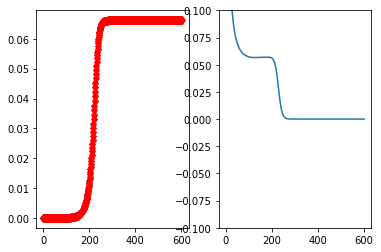

In [6]:
plt.subplot(1, 2, 1)
plt.plot(ode_n['H2O'])
plt.plot(ode_o['H2O'],'rd')
plt.subplot(1, 2, 2)
plt.plot((ode_n['H2O']-ode_o['H2O'])/ode_o['H2O'])
plt.ylim(-0.1, 0.1)

[0]	test-mae:0.453302
Will train until test-mae hasn't improved in 20 rounds.
[1]	test-mae:0.318774
[2]	test-mae:0.224532
[3]	test-mae:0.158549
[4]	test-mae:0.112232
[5]	test-mae:0.079934
[6]	test-mae:0.057279
[7]	test-mae:0.041384
[8]	test-mae:0.030354
[9]	test-mae:0.02257
[10]	test-mae:0.017162
[11]	test-mae:0.013425
[12]	test-mae:0.010808
[13]	test-mae:0.009048
[14]	test-mae:0.007841
[15]	test-mae:0.007032
[16]	test-mae:0.006486
[17]	test-mae:0.006114
[18]	test-mae:0.005861
[19]	test-mae:0.00569
[20]	test-mae:0.005555
[21]	test-mae:0.00547
[22]	test-mae:0.005403
[23]	test-mae:0.005382
[24]	test-mae:0.005369
[25]	test-mae:0.00536
[26]	test-mae:0.005354
[27]	test-mae:0.00535
[28]	test-mae:0.005347
[29]	test-mae:0.005345
[30]	test-mae:0.005343
[31]	test-mae:0.005342
[32]	test-mae:0.005341
[33]	test-mae:0.005341
[34]	test-mae:0.00534
[35]	test-mae:0.00534
[36]	test-mae:0.00534
[37]	test-mae:0.00534
[38]	test-mae:0.00534
[39]	test-mae:0.00534
[40]	test-mae:0.005339
[41]	test-mae:0.005339

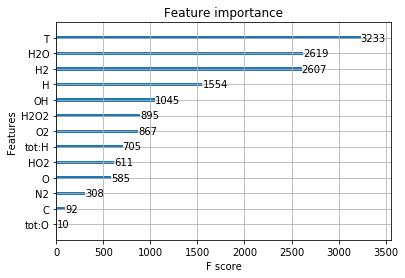

In [7]:
# load training
df_x, df_y = pickle.load(open('data/x_y_org.p', 'rb'))
columns = df_x.columns
# df_x = df_x.drop('N2', axis=1)
f = set(df_x['f'])
f = np.asarray(sorted(list(map(float, f)))).reshape(-1, 1)
df_x = df_x.drop('f', axis=1)
df_y = df_y.drop('N2', axis=1)

# get rid of Zero
indx = (df_x != 0).all(1)
df_x = df_x.loc[indx]
df_y = df_y.loc[indx]
#%%
# target study
res = (df_y - df_x) / df_x[df_x != 0]
# res = (df_y - df_x)
# res = df_y

# add new features
df_x['C'] = df_x['H2'] + df_x['H2O']

df_x['tot:O'] = 2 * df_x['O2'] + df_x['OH'] + df_x['O'] + df_x['H2O'] \
                + 2 * df_x['HO2'] + 2 * df_x['H2O2']

df_x['tot:H'] = 2 * df_x['H2'] + df_x['H'] + df_x['OH'] + 2 * df_x['H2O'] \
                + df_x['HO2'] + 2 * df_x['H2O2']

# %%
mask_train = df_x['HO2'] < 1
bstReg_gpu = {}
scalers = {}
species = ['H2O']
# species = ['H2','OH','O2','O','H2O']
# species = columns.drop(['dt','N2','f'])

for state in {'b:', 'u:'}:
    mask_train = ~mask_train

    if mask_train.any():
        df_x_masked = df_x.loc[mask_train]
        df_y_masked = res.loc[mask_train]
        # df_y_masked[df_y_masked>0.2]=np.nan
        X_train, X_test, y_train, y_test = train_test_split(df_x_masked, df_y_masked,
                                                            test_size=.1, random_state=42)

        for sp in species:
            # scaler = LogScaler()
            # scaler = AtanScaler()
            # scaler = NoScaler()
            # scaler = MinMaxScaler()
            # scaler = MaxAbsScaler()
            scaler = StandardScaler()

            outlier = 100
            target_train = scaler.fit_transform(y_train[sp].values.reshape(-1, 1))
            dtrain = xgb.DMatrix(X_train[target_train < outlier], label=target_train[target_train < outlier])

            target_test = scaler.transform(y_test[sp].values.reshape(-1, 1))
            dtest = xgb.DMatrix(X_test[target_test < outlier], label=target_test[target_test < outlier])
            param = {
                'max_depth': 10,
                'eta': 0.3,
                'silent': 1,
                'eval_metric': 'mae',
                'predictor': 'gpu_predictor',
                'objective': 'gpu:reg:linear'
            }

            num_round = 500
            bst = xgb.train(param, dtrain, num_round,
                            evals=[(dtest, 'test')], early_stopping_rounds=20)

            bstReg_gpu[state + sp] = bst
            scalers[state + sp] = scaler
            print(sp + ':', r2_score(np.exp(bst.predict(dtest)), target_test[target_test < outlier]))

xgb.plot_importance(bst)
plt.show()

# feature engineering
With xgboost the importance of the feature could be listed based on how offen it is used in building the solution model. Apart from the mass fractions for the species, the total mass for H, O and N2 are added for conservation and the progress varibale C, which is defined as $Y_{H2} + Y_{H2O}$ are added to the features.  As expected the results at n=25 is much better than n=1. To in order to imporve on the model a better data generation scheme is required. 
To further investigate the problem, the target states are seperated into two categories, H2 and O2, which are consumed and all the others, which are generated. 
The H2O example shows that in general the method has problem to get the inital formation of new species. 

0.00098313992049466 Y_H2= [0.00206617]


<Figure size 432x288 with 0 Axes>

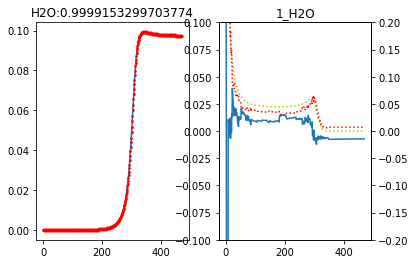

0.0009483155342732351 Y_H2= [0.23130958]


<Figure size 432x288 with 0 Axes>

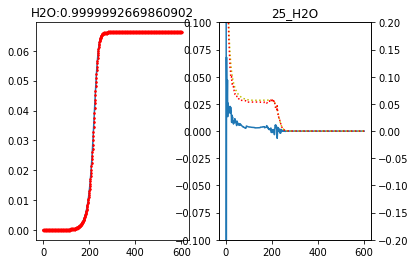

In [8]:
from boost_test import sp_plot_gpu_mask
for sp_test in species:
    # for n in [.5, 1.4, 2.6, 5, 10, 13, 25]:
    for n in [1, 25]:
        ode_o, ode_n = test_data(1501, n, columns)
        ode_o['C'] = ode_o['H2'] + ode_o['H2O']
        ode_o['tot:O'] = 2 * ode_o['O2'] + ode_o['OH'] + ode_o['O'] + ode_o['H2O'] \
                         + 2 * ode_o['HO2'] + 2 * ode_o['H2O2']
        ode_o['tot:H'] = 2 * ode_o['H2'] + ode_o['H'] + ode_o['OH'] + 2 * ode_o['H2O'] \
                         + ode_o['HO2'] + 2 * ode_o['H2O2']
        # mask_pred = (ode_o['H2'] < 0.01) | (ode_o['O2'] < 0.01)
        mask_pred = ode_o['HO2'] < 1
        # mask_pred = ~mask_pred
        sp_plot_gpu_mask(n, sp_test, bstReg_gpu, scalers, ode_o, ode_n, mask_pred)
        plt.show()